# Project 3

By Tiffany Liu

Louvain modularity algorithm for clusters of artists who influenced/worked with each other as well as relationships between departments and time periods. 


# Environment setup

In [1]:
import neo4j
import csv
import math
import numpy as np
import pandas as pd
import psycopg2
from IPython.display import display

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [4]:
cursor = connection.cursor()

## Web server interface at https://xxxx:7473

#### Update - since the videos were filmed, neo4j requires a longer, more complex password, so the newest password is here:

**Username: neo4j**

**Password: ucb_mids_w205**

**In the web server interface, run the same query from last week to return all nodes and all relationships:**

```
match (n) return n
```

In [66]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [67]:
session = driver.session(database="neo4j")

In [68]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [69]:
# def my_neo4j_run_query_pandas(query, **kwargs):
#     "run a query and return the results in a pandas dataframe"
    
#     result = session.run(query, **kwargs)
    
#     df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
#     return df

In [70]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    with driver.session() as session:
        result = session.run(query, **kwargs)
        df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [71]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

In [72]:
# def my_neo4j_number_nodes_relationships():
#     "print the number of nodes and relationships"
   
    
#     query = """
#         match (n) 
#         return n.name as node_name, labels(n) as labels
#         order by n.name
#     """
    
#     df = my_neo4j_run_query_pandas(query)
    
#     number_nodes = df.shape[0]
    
    
#     query = """
#         match (n1)-[r]->(n2) 
#         return n1.name as node_name_1, labels(n1) as node_1_labels, 
#             type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
#         order by node_name_1, node_name_2
#     """
    
#     df = my_neo4j_run_query_pandas(query)
    
#     number_relationships = df.shape[0]
    
#     print("-------------------------")
#     print("  Nodes:", number_nodes)
#     print("  Relationships:", number_relationships)
#     print("-------------------------")

In [73]:
def my_neo4j_number_nodes_relationships():
    "print the number of nodes and relationships"
   
    with driver.session() as session:
        query = """
            match (n) 
            return n.name as node_name, labels(n) as labels
            order by n.name
        """
        
        result = session.run(query)
        df = pd.DataFrame([r.values() for r in result], columns=result.keys())
        
        number_nodes = df.shape[0]
        
        query = """
            match (n1)-[r]->(n2) 
            return n1.name as node_name_1, labels(n1) as node_1_labels, 
                type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
            order by node_name_1, node_name_2
        """
        
        result = session.run(query)
        df = pd.DataFrame([r.values() for r in result], columns=result.keys())
        
        number_relationships = df.shape[0]
        
        print("-------------------------")
        print("  Nodes:", number_nodes)
        print("  Relationships:", number_relationships)
        print("-------------------------")

Use this once to start with a clean database. Wipe out the Neo4j database

In [74]:
my_neo4j_wipe_out_database() 

Verify the number of nodes and relationships

In [75]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 0
  Relationships: 0
-------------------------


### Create SQL tables and load data into tables

In [76]:
# drop all the temp tables in the foreign key order
#

connection.rollback()

query = """

drop table if exists artwork_timeperiod;
drop table if exists artwork_department;
drop table if exists artwork_artist;

drop table if exists artworks;
drop table if exists artists;
drop table if exists departments;
drop table if exists timeperiods;


"""

cursor.execute(query)

connection.commit()

In [77]:
# Create empty tables

rollback_before_flag = True
rollback_after_flag = False

query = """

create table artists (
    artist_id integer,
    artist_name text,
    primary key (artist_id)
);

create table departments (
    department_id integer,
    department text,
    primary key (department_id)
);

create table timeperiods (
    time_period_id integer,
    century text,
    century_start_year integer,
    century_end_year integer,
    primary key (time_period_id)
);

create table artworks (
    object_id integer,
    title text,
    object_begin_date integer,
    object_end_date integer,
    department text,
    century text,
    accessionyear integer,
    primary key (object_id)
);

create table artwork_artist (
    object_id integer,
    artist_id integer,
    foreign key (object_id) references artworks(object_id),
    foreign key (artist_id) references artists(artist_id)
);

create table artwork_department (
    object_id integer,
    department_id integer,
    foreign key (object_id) references artworks(object_id),
    foreign key (department_id) references departments(department_id)
);

create table artwork_timeperiod (
    object_id integer,
    time_period_id integer,
    foreign key (object_id) references artworks(object_id),
    foreign key (time_period_id) references timeperiods(time_period_id)
);

"""

cursor = connection.cursor()

if rollback_before_flag:
    connection.rollback()

cursor.execute(query)

if rollback_after_flag:
    connection.rollback()
else:
    connection.commit()

In [78]:
## load the csv files into the database tables

connection.rollback()

query = """

copy artists(artist_id, artist_name)
from '/user/projects/project-3-team-4/code/nodes_artists.csv'
delimiter ',' null '' csv header;

copy departments(department_id, department)
from '/user/projects/project-3-team-4/code/nodes_departments.csv'
delimiter ',' null '' csv header;

copy timeperiods(time_period_id,century,century_start_year,century_end_year)
from '/user/projects/project-3-team-4/code/nodes_time_periods.csv'
delimiter ',' null '' csv header;

copy artworks(object_id,title,object_begin_date,object_end_date,department,century,accessionyear)
from '/user/projects/project-3-team-4/code/nodes_artworks.csv'
delimiter ',' null '' csv header;

copy artwork_artist(object_id,artist_id)
from '/user/projects/project-3-team-4/code/edges_artwork_artist.csv'
delimiter ',' null '' csv header;

copy artwork_department(object_id,department_id)
from '/user/projects/project-3-team-4/code/edges_artwork_department.csv'
delimiter ',' null '' csv header;

copy artwork_timeperiod(object_id,time_period_id)
from '/user/projects/project-3-team-4/code/edges_artwork_time_period.csv'
delimiter ',' null '' csv header;

"""

cursor.execute(query)

connection.commit()

In [79]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artists;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,artist_id,artist_name
0,1,Louis Benjamin Huber Defeuille
1,2,Jacques Thouron
2,3,Jean-Baptiste Nini
3,4,H. Sanford
4,5,William P. Babcock
...,...,...
2559,2560,Allan Kaprow|Jasper Johns
2560,2561,Master of the Acquavella Still Life
2561,2562,Jugarsi
2562,2563,Syaji


In [80]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from departments;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,department_id,department
0,1,The American Wing
1,2,Arms and Armor
2,3,Asian Art
3,4,Modern and Contemporary Art
4,5,European Sculpture and Decorative Arts
5,6,Photographs
6,7,"Arts of Africa, Oceania, and the Americas"
7,8,Drawings and Prints
8,9,European Paintings
9,10,Islamic Art


In [81]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from timeperiods;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,time_period_id,century,century_start_year,century_end_year
0,1,18th Century CE,1701,1800
1,2,19th Century CE,1801,1900
2,3,20th Century CE,1901,2000
3,4,17th Century CE,1601,1700
4,5,1st Century CE,1,100
5,6,16th Century CE,1501,1600
6,7,11th Century CE,1001,1100
7,8,15th Century CE,1401,1500
8,9,14th Century CE,1301,1400
9,10,7th Century CE,601,700


In [82]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artworks;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,object_id,title,object_begin_date,object_end_date,department,century,accessionyear
0,466,Plaque Portrait of Benjamin Franklin,1800,1883,The American Wing,18th Century CE,1883
1,467,Plaque Portrait of Benjamin Franklin,1776,1883,The American Wing,18th Century CE,1883
2,468,Plaque Portrait of Benjamin Franklin,1776,1883,The American Wing,18th Century CE,1883
3,469,Plaque Portrait of Benjamin Franklin,1776,1883,The American Wing,18th Century CE,1883
4,470,Plaque Portrait of Benjamin Franklin,1776,1883,The American Wing,18th Century CE,1883
...,...,...,...,...,...,...,...
6009,892461,The Arts,1973,1976,Modern and Contemporary Art,20th Century CE,2023
6010,894279,The Lace Shawl,1920,1920,European Paintings,20th Century CE,2023
6011,894493,Hotel in Lecce,2021,2021,Modern and Contemporary Art,21th Century CE,2022
6012,895906,End of the Day,2019,2019,Modern and Contemporary Art,21th Century CE,2023


In [83]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artwork_department;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,object_id,department_id
0,466,1
1,467,1
2,468,1
3,469,1
4,470,1
...,...,...
6009,892461,4
6010,894279,9
6011,894493,4
6012,895906,4


In [84]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artwork_timeperiod;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,object_id,time_period_id
0,466,1
1,467,1
2,468,1
3,469,1
4,470,1
...,...,...
6009,892461,3
6010,894279,3
6011,894493,13
6012,895906,13


In [85]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from artwork_artist;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,object_id,artist_id
0,466,1
1,467,2
2,467,2529
3,468,2
4,469,2
...,...,...
5812,892461,2524
5813,894279,2525
5814,894493,2526
5815,895906,2527


## Setting up the Graph
### Creating functions to insert Nodes into Neo4j
The following parts were performed by Helin Yilmaz to create nodes for Artists, Departments, Artworks, and Time Periods

In [86]:
def create_artist(session, artist_id, artist_name):
    """Create an Artist node"""
    query = """
    MERGE (:Artist {artist_id: $artist_id, name: $artist_name})
    """
    session.run(query, artist_id=artist_id, artist_name=artist_name)


In [87]:
def create_artwork(session, object_id, title, begin_date, end_date, department, century, accessionyear):
    """Create an Artwork node"""
    query = """
    MERGE (:Artwork {object_id: $object_id, title: $title, begin_date: $begin_date, 
                      end_date: $end_date, department: $department, century: $century, 
                      accessionyear: $accessionyear})
    """
    session.run(query, object_id=object_id, title=title, begin_date=begin_date, 
                end_date=end_date, department=department, century=century, accessionyear=accessionyear)


In [88]:
def create_department(session, department_id, department_name):
    """Create a Department node"""
    query = """
    MERGE (:Department {department_id: $department_id, name: $department_name})
    """
    session.run(query, department_id=department_id, department_name=department_name)


In [89]:
def create_time_period(session, time_period_id, century, start_year, end_year):
    """Create a Time Period node"""
    query = """
    MERGE (:TimePeriod {time_period_id: $time_period_id, century: $century, 
                         start_year: $start_year, end_year: $end_year})
    """
    session.run(query, time_period_id=time_period_id, century=century, 
                start_year=start_year, end_year=end_year)


### Load Relationships into Neo4j

In [90]:
def create_artwork_artist_relationship(session, object_id, artist_id):
    """Create a relationship between an Artwork and an Artist"""
    query = """
    MATCH (a:Artwork {object_id: $object_id}), 
          (b:Artist {artist_id: $artist_id})
    MERGE (a)-[:CREATED_BY]->(b)
    """
    session.run(query, object_id=object_id, artist_id=artist_id)


In [91]:
def create_artwork_department_relationship(session, object_id, department_id):
    """Create a relationship between an Artwork and a Department"""
    query = """
    MATCH (a:Artwork {object_id: $object_id}), 
          (b:Department {department_id: $department_id})
    MERGE (a)-[:BELONGS_TO]->(b)
    """
    session.run(query, object_id=object_id, department_id=department_id)


In [92]:
def create_artwork_time_period_relationship(session, object_id, time_period_id):
    """Create a relationship between an Artwork and a Time Period"""
    query = """
    MATCH (a:Artwork {object_id: $object_id}), 
          (b:TimePeriod {time_period_id: $time_period_id})
    MERGE (a)-[:ASSOCIATED_WITH]->(b)
    """
    session.run(query, object_id=object_id, time_period_id=time_period_id)


### Load Data from SQL tables into Neo4j

In [93]:
artists_df = my_select_query_pandas("SELECT * FROM artists", False, False)
with driver.session() as session:
    for _, row in artists_df.iterrows():
        create_artist(session, row['artist_id'], row['artist_name'])


In [94]:
artworks_df = my_select_query_pandas("SELECT * FROM artworks", False, False)
with driver.session() as session:
    for _, row in artworks_df.iterrows():
        title = row['title'] if pd.notna(row['title']) and row['title'] != '' else "Untitled"
        create_artwork(session,
                       row['object_id'],
                       title,
                       row['object_begin_date'],
                       row['object_end_date'],
                       row['department'],
                       row['century'],
                       row['accessionyear'])


In [95]:
departments_df = my_select_query_pandas("SELECT * FROM departments", False, False)
with driver.session() as session:
    for _, row in departments_df.iterrows():
        create_department(session, row['department_id'], row['department'])


In [96]:
timeperiods_df = my_select_query_pandas("SELECT * FROM timeperiods", False, False)
with driver.session() as session:
    for _, row in timeperiods_df.iterrows():
        create_time_period(session, row['time_period_id'], row['century'], 
                           row['century_start_year'], row['century_end_year'])


### Establish edges between nodes for relationships

In [97]:
artwork_artist_df = my_select_query_pandas("SELECT * FROM artwork_artist", False, False)
with driver.session() as session:
    for _, row in artwork_artist_df.iterrows():
        create_artwork_artist_relationship(session, row['object_id'], row['artist_id'])


In [98]:
artwork_department_df = my_select_query_pandas("SELECT * FROM artwork_department", False, False)
with driver.session() as session:
    for _, row in artwork_department_df.iterrows():
        create_artwork_department_relationship(session, row['object_id'], row['department_id'])


In [99]:
artwork_timeperiod_df = my_select_query_pandas("SELECT * FROM artwork_timeperiod", False, False)
with driver.session() as session:
    for _, row in artwork_timeperiod_df.iterrows():
        create_artwork_time_period_relationship(session, row['object_id'], row['time_period_id'])


In [144]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 8607
  Relationships: 17844
-------------------------


## Louvain Modularity Algorithm
### Using Louvain algorithm to detect artistic communities. Then, identify clusters of artists who may have influenced each other as well as relationships between departments and time periods.

In [149]:
# Print relationship types
with driver.session() as session:
    result = session.run("""
        CALL db.relationshipTypes()
    """)
    for record in result:
        print(record["relationshipType"])

CREATED_BY
BELONGS_TO
ASSOCIATED_WITH


In [150]:
# Projection
with driver.session() as session:
    session.run("""
        CALL gds.graph.project(
            'artworkGraph',
            ['Artwork', 'Artist', 'Department', 'TimePeriod'],
            {
                CREATED_BY: {type: 'CREATED_BY', orientation: 'UNDIRECTED'},
                BELONGS_TO: {type: 'BELONGS_TO', orientation: 'UNDIRECTED'},
                ASSOCIATED_WITH: {type: 'ASSOCIATED_WITH', orientation: 'UNDIRECTED'}
            }
        )
    """)

In [151]:
# Run Louvain modularity
with driver.session() as session:
    result = session.run("""
        CALL gds.louvain.write('artworkGraph', {
            writeProperty: 'communityId'
        })
        YIELD communityCount, modularity
    """)
    for record in result:
        print(f"Communities: {record['communityCount']}, Modularity: {record['modularity']}")

Communities: 9, Modularity: 0.6133147563071338


In [154]:
# How many nodes in each community
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)
    RETURN a.communityId AS community, count(*) AS size
    ORDER BY size DESC
    """)
    for record in result:
        print(f"Community {record['community']} has {record['size']} nodes")

Community 4032 has 1827 nodes
Community 5805 has 1222 nodes
Community 2537 has 1044 nodes
Community 7837 has 996 nodes
Community 2557 has 459 nodes
Community 6902 has 312 nodes
Community 2102 has 126 nodes
Community 6625 has 26 nodes
Community 1980 has 2 nodes


In [230]:
# See all artworks in one community at a time
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)
    WHERE a.communityId = 1980
    RETURN a.title AS title, a.object_id AS object_id
    """)
    for record in result:
        print(f"Artwork Title: {record['title']}, Object ID: {record['object_id']}")

Artwork Title: Acoustics of Violins, Object ID: 504538
Artwork Title: Portrait of Monsieur Aublet, Object ID: 505722


In [168]:
# See which time periods are in each community
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)-[:ASSOCIATED_WITH]->(t:TimePeriod)
    WITH a.communityId AS community, t.century AS time_period_name
    RETURN community, time_period_name, count(*) AS count
    ORDER BY count DESC
    """)
    for record in result:
        print(f"Community {record['community']} is associated with {record['time_period_name']} with {record['count']} artworks")

Community 4032 is associated with 20th Century CE with 1811 artworks
Community 7837 is associated with 19th Century CE with 874 artworks
Community 5805 is associated with 19th Century CE with 791 artworks
Community 2537 is associated with 17th Century CE with 464 artworks
Community 2537 is associated with 18th Century CE with 446 artworks
Community 6902 is associated with 16th Century CE with 277 artworks
Community 2557 is associated with 15th Century CE with 244 artworks
Community 5805 is associated with 20th Century CE with 237 artworks
Community 5805 is associated with 18th Century CE with 175 artworks
Community 2102 is associated with 21th Century CE with 99 artworks
Community 2557 is associated with 14th Century CE with 88 artworks
Community 2557 is associated with 20th Century CE with 71 artworks
Community 2537 is associated with 19th Century CE with 56 artworks
Community 7837 is associated with 18th Century CE with 50 artworks
Community 7837 is associated with 20th Century CE wi

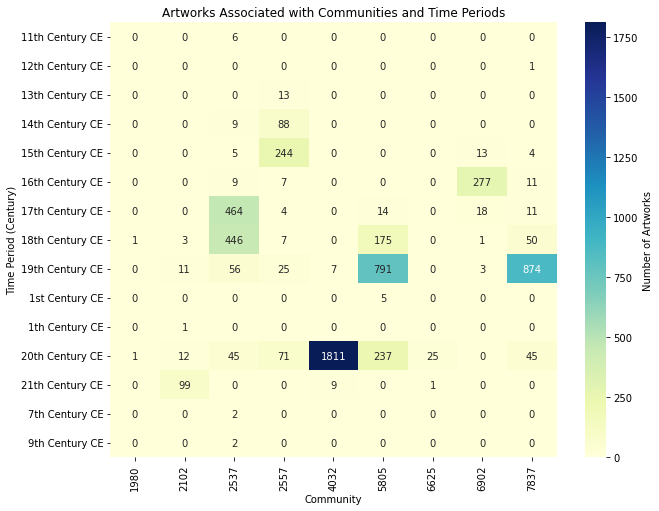

In [176]:
# Show above in a heatmap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Query
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)-[:ASSOCIATED_WITH]->(t:TimePeriod)
    WITH a.communityId AS community, t.century AS time_period_name
    RETURN community, time_period_name, count(*) AS count
    ORDER BY count DESC
    """)
    
    # Put result in dictionary
    data = []
    for record in result:
        data.append({
            'community': record['community'],
            'time_period_name': record['time_period_name'],
            'count': record['count']
        })
    
# Convert to pivot df
df = pd.DataFrame(data)
pivot_df = df.pivot_table(index='time_period_name', columns='community', values='count', aggfunc='sum', fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Number of Artworks'})
plt.title("Artworks Associated with Communities and Time Periods")
plt.ylabel("Time Period (Century)")
plt.xlabel("Community")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [178]:
# See which departments are in each community
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)-[:BELONGS_TO]->(d:Department)
    WITH a.communityId AS community, d.name AS department
    RETURN community, department, count(*) AS count
    ORDER BY count DESC
    """)
    for record in result:
        print(f"Community {record['community']} is associated with {record['department']} with {record['count']} artworks")

Community 4032 is associated with Modern and Contemporary Art with 1809 artworks
Community 5805 is associated with The American Wing with 1221 artworks
Community 7837 is associated with European Paintings with 919 artworks
Community 2537 is associated with European Paintings with 674 artworks
Community 2537 is associated with Asian Art with 299 artworks
Community 6902 is associated with European Paintings with 267 artworks
Community 2557 is associated with European Paintings with 217 artworks
Community 2557 is associated with Robert Lehman Collection with 200 artworks
Community 2102 is associated with Modern and Contemporary Art with 80 artworks
Community 2537 is associated with Islamic Art with 41 artworks
Community 2102 is associated with Arts of Africa, Oceania, and the Americas with 32 artworks
Community 7837 is associated with Asian Art with 31 artworks
Community 7837 is associated with Robert Lehman Collection with 30 artworks
Community 6625 is associated with Photographs with 26

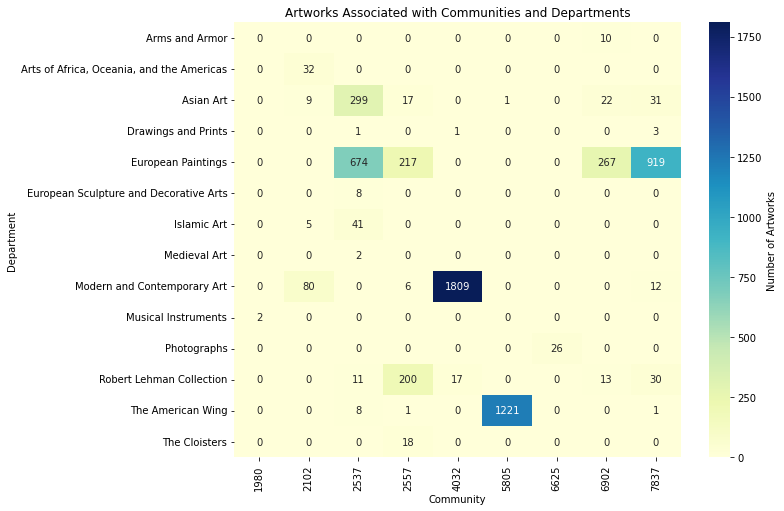

In [179]:
# Show above in a heatmap
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)-[:BELONGS_TO]->(d:Department)
    WITH a.communityId AS community, d.name AS department
    RETURN community, department, count(*) AS count
    ORDER BY count DESC
    """)
    
    # Put result in dictionary
    data = []
    for record in result:
        data.append({
            'community': record['community'],
            'department': record['department'],
            'count': record['count']
        })
    
# Convert to pivot df
df = pd.DataFrame(data)
pivot_df = df.pivot_table(index='department', columns='community', values='count', aggfunc='sum', fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Number of Artworks'})
plt.title("Artworks Associated with Communities and Departments")
plt.ylabel("Department")
plt.xlabel("Community")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [181]:
# Count of artworks per artist per community
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)-[:CREATED_BY]->(art:Artist)
    RETURN a.communityId AS community, art.name AS artist, count(*) AS count
    ORDER BY count DESC
    """)
    data = []
    for record in result:
        data.append({
            'community': record['community'],
            'artist': record['artist'],
            'count': record['count']
        })
    
# Show in df
count_df = pd.DataFrame(data)
count_df

,community,artist,count
0,5805,John Singer Sargent,40
1,7837,Claude Monet,39
2,4032,Pablo Picasso,37
3,7837,Camille Corot,36
4,2537,Unidentified artist,33
...,...,...,...
2584,4032,Allan Kaprow|Jasper Johns,1
2585,2537,Master of the Acquavella Still Life,1
2586,2537,Jugarsi,1
2587,2537,Syaji,1


In [232]:
# List of artists in each community
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)-[:CREATED_BY]->(art:Artist)
    WITH a.communityId AS community, collect(DISTINCT art.name) AS artists
    RETURN community, artists
    ORDER BY community
    """)
    data = []
    for record in result:
        data.append({
            'community': record['community'],
            'artists': record['artists']
        })

# Show in df
artists_in_community_df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
artists_in_community_df

,community,artists
0,1980,"[Marvin Mattelson, Guillaume Voiriot]"
1,2102,"[Shao Fan, Lunda Hoyle Gill, Ephrem Kouakou, Shirazeh Houshiary, Samira Abbassy, Fereydoun Ave, Seyed Mohammad Ehsaey, Malcolm Morley, Julian Lethbridge, Kay WalkingStick, Anselm Kiefer, Julian Hatton, Jim Torok, Karel Nel, William Scott, Francesco Clemente, Betty Woodman, D. J. Hall, Cecily Brown, Peter Sacks, George Condo, Dennis Hopper, Jenny Saville, Amy Bennett, Radcliffe Bailey, Jenny Holzer, Chantal Joffe, Nate Lowman, Donald Moffett, Tenzing Rigdol, Nasrollah Afjei, Mark Bradford, Qiu Shihua, Thornton Dial, Doreen Reid Nakamarra, Dorothy Napangardi, Abie Loy Kemarre, Lena Nyadbi, Gunybi Ganambarr, Adriana Varejão, Sophie von Hellermann, Kerry James Marshall, Kojo Griffin, Qiu Anxiong, Li Huasheng, Adam McEwen, Zheng Chongbin, Carmen Herrera, Amy Sillman, Prabhavathi Meppayil, Adrian Ghenie, Stanley Whitney, Etel Adnan, Shara Hughes, Henry Taylor, Steven Shearer, Waigan Djanghara, Michael Armitage, Carrie Moyer, Peter Doig, Robert Mangold, Nonggirrnga Marawili, Gulumbu Yunupingu, Angelina Pwerle, Carlene West, Wintjiya Napaltjarri, Yukultji Napangati, Jonas Wood, Skunder Boghossian, Raqib Shaw, Wade Guyton, Titus Kaphar, Sosa Joseph, Julie Mehretu, Reggie Burrows Hodges, Wu Jian’an, Julia Rommel, Jadé Fadojutimi, Maggi Hambling, Khalil Rabah, Nicole Eisenman, Maysha Mohamedi, María Berrío, Salman Toor, Louis Fratino, Matthew Wong, Christine Ay Tjoe]"
2,2537,"[John Smibert, Sir Godfrey Kneller, Angelica Kauffmann, Unidentified artist, Ogawa Haritsu (Ritsuō), Guan Liang, Ustad Mohamed, son of Murad, Sahib Ram, Pannalai, Nainsukh, A Master of the Mandi atelier, Sri Prathi Singh of Ratlam, Shiva and Dayal, Chokha, Bagta, Chotu, Bhavani Das, Sheikh Taju, Bakhta, Stipple Master, Utagawa Hiroshige, Hishikawa Moronobu 菱川師宣, Utagawa Kuniyoshi, Sesson Shūkei, Samoje, Li Keran, Kano Shōun, Kubo Shunman, Utagawa Kuniteru, Katsushika Hokusai, Tsukioka Sessai, Kaigetsudō, Ogata Kōrin, Xugu (Zhu Huairen), Wu Changshuo, Fan Zeng, Mao Zuyuan, Wu Shiming, Sesshū Tōyō 雪舟等楊, Kakuho, Kitagawa Utamaro, Shibata Zeshin, Hokusai School, Kawanabe Kyōsai 河鍋暁斎, Miki Suizan, Toyosei Kimigi, Hashimoto Kansetsu 橋本関雪, Matsuo Bashō, Tara, Dalchand, The Kota Master, Nihal Chand, Xie Zhiliu, Ala Bagas, Ghasi, Seu Family, Manak, Ragunath, Y. G. Srimati, Kota Master A, Niju, Minol Araki 荒木實, Giovanni da Udine (Giovanni dei Ricamatori), François Boucher, Willem van Leen, John Wootton, Antonio Zucchi, Sir Joshua Reynolds, Jacopo Amigoni, Jacques d'Arthois, Jacob Backer, David Bailly, Pompeo Batoni, Sir William Beechey, Johannes Abrahamsz Beerstraten, Bernardo Bellotto, Nicolaes Berchem, Abraham van Beyeren, Cornelis Bisschop, William Blake, Jacques Blanchard, Henri Joseph van Blarenberghe, Ferdinand Bol, Paulus Bor, Gerard ter Borch the Younger, Anthonie van Borssom, Giuseppe Bottani, Sébastien Bourdon, Leonaert Bramer, Bartholomeus Breenbergh, Quirijn van Brekelenkam, Jan Brueghel the Elder, Jan Brueghel the Younger, Hendrick ter Brugghen, Francesco Cairo, Canaletto (Giovanni Antonio Canal), Jan van de Cappelle, Francesco Casanova, Bernardo Cavallino, Giacomo Ceruti, ...]"
3,2557,"[Unidentified artist, Sakya School, Kano Motonobu, Tang Yin, Spanish Painter, Fra Angelico (Guido di Pietro), Zanobi Strozzi, Antonello da Messina (Antonello di Giovanni d'Antonio), Antoniazzo Romano (Antonio di Benedetto Aquilio), Ercole Banci, Fra Bartolomeo (Bartolomeo di Paolo del Fattorino), Bartolomeo degli Erri, Giovanni Bellini, Jacopo Bellini, Bergognone (Ambrogio di Stefano da Fossano), Berlinghiero, Biagio d'Antonio, Botticelli (Alessandro di Mariano Filipepi), Botticelli, Francesco Botticini (Francesco di Giovanni), Dieric Bouts, Hans Traut, Budapest Master, Rogier van der Weyden, Robert Campin, Fra Carnevale (Bartolomeo di Giovanni Corradini), Vittore Carpaccio, Cenni di Francesco di Ser Cenni, Petrus Christus, Carlo Crivelli, Vittore Crivelli, Bernardo Daddi, Gerard David, Vincenzo Foppa, Franc

In [227]:
# See if Munch and Van Gogh are in same community
munch_vangogh = artists_in_community_df[artists_in_community_df['artists'].apply(lambda x: any(artist in x for artist in ['Edvard Munch', 'Vincent van Gogh']))]
munch_vangogh

,community,artists
8,7837,"[George Chinnery, George Chinnery, George Chinnery, British Painter, British Painter, British Painter, British Painter, British Painter, Anonymous, Czech, early 20th century, Abram Efimovich Arkhipov, Dionisio Baixeras y Verdaguer, Charles Bargue, Charles Bargue, Jules Bastien-Lepage, Jean-Frédéric Bazille, Charles-Edouard de Beaumont, Gyula Benczúr, Benjamin-Constant (Jean-Joseph-Benjamin Constant), Benjamin-Constant (Jean-Joseph-Benjamin Constant), Benjamin-Constant (Jean-Joseph-Benjamin Constant), Benjamin-Constant (Jean-Joseph-Benjamin Constant), Marie Guillelmine Benoist, Jean Béraud, Jean Béraud, Jean Béraud, Arnold Böcklin, Arnold Böcklin, Louis Léopold Boilly, Louis Léopold Boilly, Louis Léopold Boilly, Louis Léopold Boilly, Louis Léopold Boilly, Giovanni Boldini, Giovanni Boldini, Giovanni Boldini, Giovanni Boldini, Auguste-François Bonheur, Auguste-François Bonheur, Rosa Bonheur, Rosa Bonheur, Rosa Bonheur, Richard Parkes Bonington, Richard Parkes Bonington, Léon Bonnat, Léon Bonnat, Léon Bonnat, Eugène Boudin, Eugène Boudin, Eugène Boudin, Eugène Boudin, Eugène Boudin, Eugène Boudin, Eugène Boudin, William Bouguereau, William Bouguereau, William Bouguereau, Jules Breton, Jules Breton, John Brett, Adriaen Brouwer, Adriaen Brouwer, Adriaen Brouwer, Adriaen Brouwer, Sir Edward Burne-Jones, Alexandre Cabanel, Alexandre Cabanel, Alexandre Cabanel, Alexandre Cabanel, Carolus-Duran (Charles-Auguste-Emile Durant), Carolus-Duran (Charles-Auguste-Emile Durant), Eugène Carrière, Eugène Carrière, Eugène Carrière, Théodore Caruelle d'Aligny, Théodore Caruelle d'Aligny, Théodore Caruelle d'Aligny, Jean-Charles Cazin, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, Paul Cézanne, ...]"


Edvard Munch admired Vincent Van Gogh’s work, and they were both part of the post-impressionist movement. It makes sense that they're in the same community.

In [215]:
# See if Braque and Picasso are in same community
braque_picassso = artists_in_community_df[artists_in_community_df['artists'].apply(lambda x: any(artist in x for artist in ['Georges Braque', 'Pablo Picasso']))]
braque_picassso

,community,artists
4,4032,"[Unknown Artist, Unknown Artist, Salvador Dalí, Salvador Dalí, Salvador Dalí, Salvador Dalí, Salvador Dalí, Ben Shahn, Kenneth Callahan, Kenneth Callahan, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Pierre Bonnard, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Georges Braque, Marc Chagall, Marc Chagall, Marc Chagall, Marc Chagall, Marc Chagall, Marc Chagall, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, André Derain, Edouard Vuillard, Edouard Vuillard, Edouard Vuillard, Albert Marquet, Albert Marquet, Albert Marquet, Albert Marquet, Albert Marquet, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, Henri Matisse, ...]"


Georges Braque and Pablo Picasso were close friends and collaborators in the development of Cubism. It makes sense that they're in the same community.

In [183]:
# Show all
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)-[:ASSOCIATED_WITH]->(t:TimePeriod),
          (a)-[:BELONGS_TO]->(d:Department),
          (a)-[:CREATED_BY]->(art:Artist)
    WITH a.communityId AS community, t.century AS time_period, d.name AS department, art.name AS artist
    RETURN community, time_period, department, collect(artist) AS artists
    ORDER BY community, time_period
    """)
    data = []
    for record in result:
        data.append({
            'community': record['community'],
            'time_period': record['time_period'],
            'department': record['department'],
            'artists': record['artists']
        })
    
# Show df
all_df = pd.DataFrame(data)
all_df

,community,time_period,department,artists
0,1980,18th Century CE,Musical Instruments,[Guillaume Voiriot]
1,1980,20th Century CE,Musical Instruments,[Marvin Mattelson]
2,2102,19th Century CE,"Arts of Africa, Oceania, and the Americas","[Lunda Hoyle Gill, Lunda Hoyle Gill]"
3,2102,20th Century CE,Asian Art,[Li Huasheng]
4,2102,20th Century CE,"Arts of Africa, Oceania, and the Americas","[Skunder Boghossian, Waigan Djanghara, Ephrem ..."
...,...,...,...,...
84,7837,19th Century CE,Modern and Contemporary Art,"[Charles Rennie Mackintosh, Charles Rennie Mac..."
85,7837,19th Century CE,Drawings and Prints,"[Zubelda Cigarettes, Zubelda Cigarettes, Anony..."
86,7837,19th Century CE,European Paintings,"[Giuseppe Abbati, François-Auguste Biard, Frit..."
87,7837,19th Century CE,Robert Lehman Collection,"[Jean Béraud, Narcisse-Virgile Diaz de la Peña..."


In [185]:
community_1980 = all_df[all_df['community'] == 1980]
community_1980

,community,time_period,department,artists
0,1980,18th Century CE,Musical Instruments,[Guillaume Voiriot]
1,1980,20th Century CE,Musical Instruments,[Marvin Mattelson]


In [186]:
community_6625 = all_df[all_df['community'] == 6625]
community_6625

,community,time_period,department,artists
66,6625,20th Century CE,Photographs,"[Charles Clough, Charles Clough, Hanns Skolle,..."
67,6625,21th Century CE,Photographs,[Elisheva Biernoff]


In [187]:
community_2102 = all_df[all_df['community'] == 2102]
community_2102

,community,time_period,department,artists
2,2102,19th Century CE,"Arts of Africa, Oceania, and the Americas","[Lunda Hoyle Gill, Lunda Hoyle Gill]"
3,2102,20th Century CE,Asian Art,[Li Huasheng]
4,2102,20th Century CE,"Arts of Africa, Oceania, and the Americas","[Skunder Boghossian, Waigan Djanghara, Ephrem ..."
5,2102,21th Century CE,Asian Art,"[Wu Jian’an, Zheng Chongbin, Li Huasheng, Qiu ..."
6,2102,21th Century CE,Modern and Contemporary Art,"[Christine Ay Tjoe, Matthew Wong, Louis Fratin..."
7,2102,21th Century CE,"Arts of Africa, Oceania, and the Americas","[Gulumbu Yunupingu, Gulumbu Yunupingu, Nonggir..."
8,2102,21th Century CE,Islamic Art,"[Nasrollah Afjei, Seyed Mohammad Ehsaey, Ferey..."


In [189]:
community_6902 = all_df[all_df['community'] == 6902]
community_6902

,community,time_period,department,artists
68,6902,15th Century CE,European Paintings,"[Gerard David, Andrea Solario, Netherlandish P..."
69,6902,16th Century CE,Arms and Armor,"[Italian (Ferrarese) Painter, Italian (Ferrare..."
70,6902,16th Century CE,Asian Art,"[Kano Shōun, Zhao Songxue, Tosa School, Kano S..."
71,6902,16th Century CE,European Paintings,"[Francesco Salviati (Francesco de' Rossi), Gir..."
72,6902,16th Century CE,Robert Lehman Collection,"[Netherlandish, El Greco (Domenikos Theotokopo..."
73,6902,17th Century CE,European Paintings,"[Ludovico Carracci, Carlo Saraceni, Caravaggio..."
74,6902,18th Century CE,European Paintings,[Italian Painter]
75,6902,19th Century CE,Arms and Armor,"[Ferdinand Humbert, Stephen William Shaw]"
76,6902,19th Century CE,European Paintings,[Netherlandish Painter]


In [190]:
community_2557 = all_df[all_df['community'] == 2557]
community_2557

,community,time_period,department,artists
34,2557,13th Century CE,Asian Art,"[Unidentified artist, Unidentified artist]"
35,2557,13th Century CE,European Paintings,"[Duccio di Buoninsegna, Master of Varlungo, No..."
36,2557,13th Century CE,Robert Lehman Collection,"[Italian [Tuscan] Painter, first quarter of 14..."
37,2557,14th Century CE,European Paintings,[Stefano da Verona (Stefano di Giovanni d'Arbo...
38,2557,14th Century CE,Robert Lehman Collection,"[Segna di Buonaventura, Segna di Buonaventura,..."
39,2557,14th Century CE,The Cloisters,"[Niccolò di Tommaso, Master of the Codex of Sa..."
40,2557,15th Century CE,Asian Art,"[Tang Yin, Kano Motonobu, Sakya School]"
41,2557,15th Century CE,European Paintings,"[Bergognone (Ambrogio di Stefano da Fossano), ..."
42,2557,15th Century CE,Robert Lehman Collection,"[Workshop of Fra Filippo Lippi, Pietro di Giov..."
43,2557,15th Century CE,The Cloisters,"[Master of Saint Augustine, Master of Belmonte..."


In [191]:
community_7837 = all_df[all_df['community'] == 7837]
community_7837

,community,time_period,department,artists
77,7837,12th Century CE,European Paintings,[European Painter]
78,7837,15th Century CE,European Paintings,"[French Painter, French Painter, German Painte..."
79,7837,16th Century CE,European Paintings,"[French Painter, French Painter, French Painte..."
80,7837,17th Century CE,European Paintings,"[Johannes Vermeer, Johannes Vermeer, Johannes ..."
81,7837,18th Century CE,European Paintings,"[Louis Léopold Boilly, French Painter, German ..."
82,7837,18th Century CE,Robert Lehman Collection,"[Théodore Rousseau, Goya (Francisco de Goya y ..."
83,7837,19th Century CE,The American Wing,"[Ester Speakman, George Chinnery]"
84,7837,19th Century CE,Modern and Contemporary Art,"[Charles Rennie Mackintosh, Charles Rennie Mac..."
85,7837,19th Century CE,Drawings and Prints,"[Zubelda Cigarettes, Zubelda Cigarettes, Anony..."
86,7837,19th Century CE,European Paintings,"[Giuseppe Abbati, François-Auguste Biard, Frit..."


In [192]:
community_2537 = all_df[all_df['community'] == 2537]
community_2537

,community,time_period,department,artists
9,2537,14th Century CE,Asian Art,"[Unidentified artist, Li Gonglin, Unidentified..."
10,2537,14th Century CE,European Sculpture and Decorative Arts,"[Giovanni da Udine (Giovanni dei Ricamatori), ..."
11,2537,15th Century CE,Asian Art,"[Unidentified artist, Unidentified artist, Uni..."
12,2537,16th Century CE,Asian Art,"[Unidentified artist, Unidentified artist, Uni..."
13,2537,16th Century CE,European Paintings,"[Rembrandt, Rembrandt, Rembrandt]"
14,2537,17th Century CE,The American Wing,[Sir Godfrey Kneller]
15,2537,17th Century CE,Asian Art,"[Stipple Master, Wang Jian, The Kota Master, N..."
16,2537,17th Century CE,European Sculpture and Decorative Arts,"[Willem van Leen, French Painter, François Bou..."
17,2537,17th Century CE,European Paintings,"[Rachel Ruysch, Michiel van Musscher, Johann L..."
18,2537,17th Century CE,Robert Lehman Collection,"[Pieter de Hooch, Pieter de Hooch, Gerard ter ..."


In [193]:
community_5805 = all_df[all_df['community'] == 5805]
community_5805

,community,time_period,department,artists
60,5805,17th Century CE,The American Wing,"[Unknown, Unknown, Unknown, Boetius Adams Bols..."
61,5805,18th Century CE,The American Wing,"[Nicolás Rodríguez Juárez, Domingo Ortiz, Unkn..."
62,5805,19th Century CE,The American Wing,"[Julie Hart Beers, Mary Cassatt, Alfred Wordsw..."
63,5805,1st Century CE,The American Wing,"[Helena de Kay, Helena de Kay, Helena de Kay, ..."
64,5805,1st Century CE,Asian Art,[Unidentified artist]
65,5805,20th Century CE,The American Wing,"[J. Carroll Beckwith, Helen Hardin, Hilda Belc..."


In [194]:
community_4032 = all_df[all_df['community'] == 4032]
community_4032

,community,time_period,department,artists
55,4032,19th Century CE,Modern and Contemporary Art,"[Pierre Bonnard, Pierre Bonnard, Pierre Bonnar..."
56,4032,20th Century CE,Modern and Contemporary Art,"[Josef Albers, Uzo Egonu, Evelyn Statsinger, D..."
57,4032,20th Century CE,Drawings and Prints,[Kenneth Callahan]
58,4032,20th Century CE,Robert Lehman Collection,"[Salvador Dalí, Suzanne Valadon, Balthus (Balt..."
59,4032,21th Century CE,Modern and Contemporary Art,"[Frank Bowling, David Bates, Jane Wilson, Alex..."


In [196]:
# Show all time periods and departments in each community
with driver.session() as session:
    result = session.run("""
    MATCH (a:Artwork)-[:ASSOCIATED_WITH]->(t:TimePeriod),
          (a)-[:BELONGS_TO]->(d:Department)
    WITH a.communityId AS community, collect(DISTINCT t.century) AS time_periods, collect(DISTINCT d.name) AS departments
    RETURN community, time_periods, departments
    ORDER BY community
    """)
    data = []
    for record in result:
        data.append({
            'community': record['community'],
            'time_periods': record['time_periods'],
            'departments': record['departments']
        })
    
# Show df
community_table_df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
community_table_df

,community,time_periods,departments
0,1980,"[18th Century CE, 20th Century CE]",[Musical Instruments]
1,2102,"[21th Century CE, 20th Century CE, 18th Century CE, 1th Century CE, 19th Century CE]","[Asian Art, Modern and Contemporary Art, Arts of Africa, Oceania, and the Americas, Islamic Art]"
2,2537,"[18th Century CE, 17th Century CE, 19th Century CE, 9th Century CE, 20th Century CE, 11th Century CE, 15th Century CE, 16th Century CE, 14th Century CE, 7th Century CE]","[The American Wing, Asian Art, European Sculpture and Decorative Arts, Drawings and Prints, European Paintings, Islamic Art, Robert Lehman Collection, Medieval Art]"
3,2557,"[17th Century CE, 14th Century CE, 15th Century CE, 13th Century CE, 19th Century CE, 18th Century CE, 16th Century CE, 20th Century CE]","[The American Wing, Asian Art, Modern and Contemporary Art, European Paintings, Robert Lehman Collection, The Cloisters]"
4,4032,"[20th Century CE, 21th Century CE, 19th Century CE]","[Modern and Contemporary Art, Drawings and Prints, Robert Lehman Collection]"
5,5805,"[20th Century CE, 18th Century CE, 19th Century CE, 1st Century CE, 17th Century CE]","[The American Wing, Asian Art]"
6,6625,"[21th Century CE, 20th Century CE]",[Photographs]
7,6902,"[16th Century CE, 19th Century CE, 17th Century CE, 15th Century CE, 18th Century CE]","[Arms and Armor, Asian Art, European Paintings, Robert Lehman Collection]"
8,7837,"[19th Century CE, 20th Century CE, 18th Century CE, 17th Century CE, 15th Century CE, 16th Century CE, 12th Century CE]","[The American Wing, Asian Art, Modern and Contemporary Art, Drawings and Prints, European Paintings, Robert Lehman Collection]"


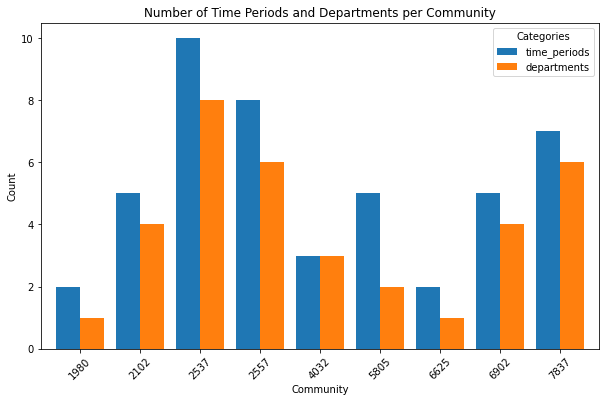

In [229]:
# Count of distinct time periods and departments per community
community_summary = community_table_df.groupby('community').agg({
    'time_periods': lambda x: len(set([item for sublist in x for item in sublist])),  # count distinct time periods
    'departments': lambda x: len(set([item for sublist in x for item in sublist]))  # count distinct departments
})

# Combined bar chart
community_summary.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Number of Time Periods and Departments per Community')
plt.ylabel('Count')
plt.xlabel('Community')
plt.xticks(rotation=45)
plt.legend(title="Categories")
plt.show()

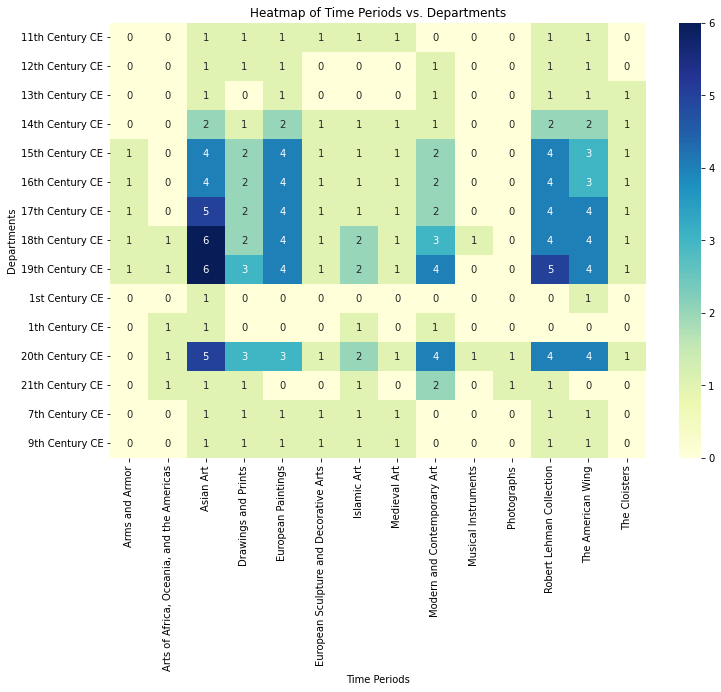

In [241]:
# Heatmap time periods vs departments
time_dept_counts_matrix = community_table_df.explode('time_periods').explode('departments')
pivot_table = time_dept_counts_matrix.groupby(['time_periods', 'departments']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt="d", cbar=True)
plt.title('Heatmap of Time Periods vs. Departments')
plt.xlabel('Time Periods')
plt.ylabel('Departments')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()